<!-- Projeto Desenvolvido na Data Science Academy - www.datascienceacademy.com.br -->
# <font color='blue'>Data Science Academy</font>
## <font color='blue'>Inteligência Artificial Para Visão Computacional</font>
## <font color='blue'>Projeto 7</font>
## <font color='blue'>Seleção e Deploy de Modelo de Visão Computacional</font>

<!-- Projeto Desenvolvido na Data Science Academy - www.datascienceacademy.com.br -->
## Instalando e Carregando os Pacotes

In [1]:
# Instala o pacote watermark.
# Esse pacote é usado para gravar as versões de outros pacotes usados neste jupyter notebook.
!pip install -q -U watermark

https://pytorch.org/vision/stable/index.html

In [2]:
!pip install -q torch

In [3]:
!pip install -q torchvision

In [4]:
# Imports
import os
import io
import time
import torch
import random
import numpy as np
import pandas as pd
import pickle
import urllib.request
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as T
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
from collections import Counter
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
from torchvision.models import resnet18, ResNet18_Weights, resnet152, ResNet152_Weights
import warnings
warnings.filterwarnings('ignore')

In [5]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Data Science Academy"

Author: Data Science Academy



In [6]:
# Detalhes da GPU (se disponível)
if torch.cuda.is_available():
    print('Número de GPUs:', torch.cuda.device_count())
    print('Modelo GPU:', torch.cuda.get_device_name(0))
    print('Total Memória [GB] da GPU:', torch.cuda.get_device_properties(0).total_memory / 1e9)
else:
    print('GPU Não Disponível!')

Número de GPUs: 1
Modelo GPU: NVIDIA GeForce RTX 3080 Laptop GPU
Total Memória [GB] da GPU: 8.361017344


## Carregando o Conjunto de Dados de Imagens

**O conjunto de dados de classificação de material reciclável contém 6 grupos de imagens:** 

* cardboard 
* glass 
* metal 
* paper 
* plastic 
* trash

Cada grupo será uma classe em nosso modelo.
<!-- Projeto Desenvolvido na Data Science Academy - www.datascienceacademy.com.br -->

In [7]:
# Pasta com as imagens
data_dir = Path('dados')

In [8]:
# Transformação
transformador = T.Compose([T.Resize((256, 256)), T.ToTensor()])

In [9]:
# Carrega as imagens a aplica as transformações
dataset = ImageFolder(data_dir, transform = transformador)

In [10]:
type(dataset)

torchvision.datasets.folder.ImageFolder

In [11]:
# Classes das imagens
print(dataset.classes)

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


In [12]:
type(dataset)

torchvision.datasets.folder.ImageFolder

> Vamos contar as imagens por pasta.

In [13]:
# Obter os rótulos e caminhos das imagens
labels = [item[1] for item in dataset.imgs]
classes = dataset.classes

# Contar o número de imagens por pasta
image_count_per_class = Counter(labels)

# Mapear os índices de rótulos para os nomes das pastas
image_count_per_folder = {classes[idx]: count for idx, count in image_count_per_class.items()}

# Criar uma lista apenas com as contagens
image_counts = [count for count in image_count_per_class.values()]

# Exibir o resultado
for folder, count in image_count_per_folder.items():
    print(f'Pasta --> {folder}, Número de imagens: {count}')

Pasta --> cardboard, Número de imagens: 403
Pasta --> glass, Número de imagens: 501
Pasta --> metal, Número de imagens: 410
Pasta --> paper, Número de imagens: 594
Pasta --> plastic, Número de imagens: 482
Pasta --> trash, Número de imagens: 137


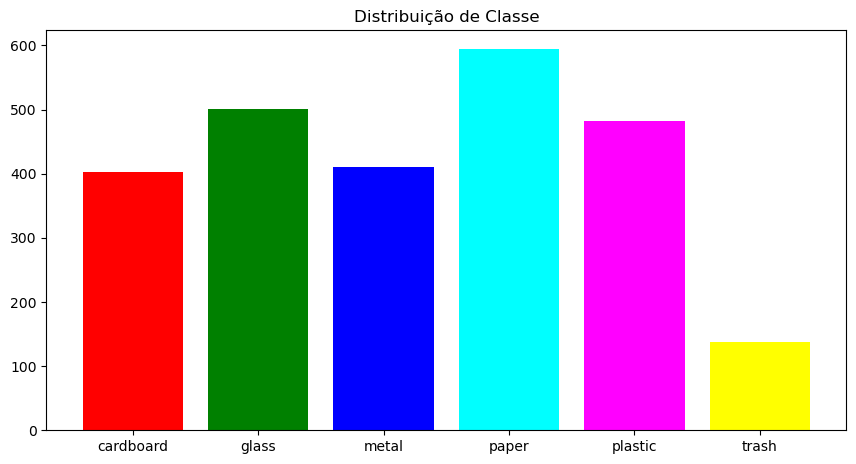

In [14]:
# Plot

# Ajustar tamanho da figura
fig = plt.figure(figsize = (8, 4))

# Criar um objeto de eixos
ax = fig.add_axes([0, 0, 1, 1])

# Plotar o gráfico de barras com cores personalizadas
counts = image_counts
colors = ['red', 'green', 'blue', 'cyan', 'magenta', 'yellow']
ax.bar(dataset.classes, counts, color = colors)

# Adicionar título
plt.title('Distribuição de Classe')

# Exibir o gráfico
plt.show()

## Preparação das Imagens

In [15]:
# Função de split (divisão 90/5/5)
def split(length) -> tuple:
    r = .05 
    test_val = int(round(length * r, 0))
    train = int(round(length - test_val * 2, 0))
    return (train, test_val, test_val)

In [16]:
# Split randômico das imagens
dados_treino, dados_teste, dados_valid = random_split(dataset, split(len(dataset)), 
                                                      generator = torch.Generator().manual_seed(42))

In [17]:
print(f'Splits: {(len(dados_treino),len(dados_teste),len(dados_valid))}') 

Splits: (2275, 126, 126)


In [18]:
# Tamanho do batch
batch_size = 16

Um DataLoader no PyTorch permite o carregamento de dados de treinamento em pequenos pacotes (lotes) durante o treinamento de modelos de aprendizado profundo. 
<!-- Projeto Desenvolvido na Data Science Academy - www.datascienceacademy.com.br -->
DataLoader é uma camada de abstração sobre a fonte de dados (por exemplo, um conjunto de dados em disco) que facilita o acesso aos dados e permite a configuração de diferentes tipos de comportamentos como o embaralhamento dos dados, o uso de vários processos de subprocessamento, etc. 

Além disso, o DataLoader também permite que você trabalhe com datasets de tamanho maior do que a memória do seu dispositivo, pois ele permite que você carregue os dados em pedaços (lotes) durante o treinamento.

In [19]:
# Data Loader de treino
dl_treino = DataLoader(dataset = dados_treino, 
                       batch_size = batch_size, 
                       shuffle = True, 
                       num_workers = 4, 
                       pin_memory = True)

In [20]:
# Data Loader de teste
dl_teste = DataLoader(dataset = dados_teste, 
                      batch_size = batch_size, 
                      num_workers = 4, 
                      pin_memory = True)

In [21]:
# Data Loader de validação
dl_valid = DataLoader(dataset = dados_valid, 
                      batch_size = batch_size, 
                      num_workers = 4, 
                      pin_memory = True)

O parâmetro pin_memory na classe DataLoader do PyTorch é usado para especificar se os dados carregados pelo dataloader devem ser alocados em uma memória compartilhada entre a CPU e a GPU.
<!-- Projeto Desenvolvido na Data Science Academy - www.datascienceacademy.com.br -->
Quando pin_memory é definido como True, o PyTorch move automaticamente os tensores de saída do dataloader para a memória compartilhada entre a CPU e a GPU. Isto ajuda a melhorar o desempenho da GPU ao realizar a transferência dos tensores para a GPU, pois essa área de memória é acessível mais rapidamente pela GPU.

No entanto, tenha em mente que essa alocação de memória também ocupa mais espaço na memória do sistema, por isso é importante usar pin_memory com cuidado. Além disso, observe que a utilização de pin_memory só é eficaz quando você está usando uma GPU, caso contrário, não fará nenhuma diferença.

### Transferindo os Data Loaders Para o Dispositivo (CPU ou GPU)

Se você tiver GPU Nvidia na sua máquina, verifique se ela é compatível com Deep Learning (Compute Capability igual ou maior do que 3):

https://developer.nvidia.com/cuda-gpus

E então instale a plataforma CUDA:

https://developer.nvidia.com/cuda-toolkit

In [22]:
# Define o device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [23]:
print(device)

cuda


In [24]:
# Função que move os tensores para o device
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [25]:
# Classe usada para transferir os data loaders para o device
class DeviceDataLoader():

    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for batch in self.dl: 
            yield to_device(batch, self.device)

    def __len__(self):
        return len(self.dl)

In [26]:
# Move os data loaders para o device
dl_treino = DeviceDataLoader(dl_treino, device)
dl_teste = DeviceDataLoader(dl_teste, device)
dl_valid = DeviceDataLoader(dl_valid, device)

### Visualizando as Imagens

In [27]:
# Função para extrair imagens do data loader 
def visualiza_batch(dl):

    # Área de plotagem
    fig, ax = plt.subplots(figsize = (15, 10))
    
    # Loop
    for images, labels in dl:
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images.cpu(), nrow = batch_size//2).permute(1, 2, 0))
        break

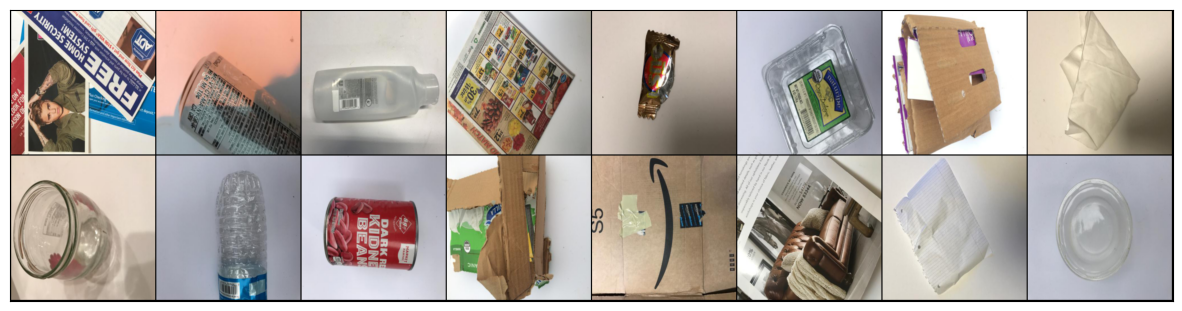

In [28]:
visualiza_batch(dl_treino)

## Construção dos Modelos

Modelos pré-treinados: https://pytorch.org/vision/main/models/resnet.html

### Definindo o Modelo Base

In [29]:
# Função para calcular a acurácia do modelo
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim = 1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

O videobook no Capítulo 13 traz detalhes sobre nn.Module.

In [30]:
# Modelo base
class ImageClassificationBase(nn.Module):
    
    # Construtor
    def __init__(self):
        super().__init__()
        self.history = None
        self.maxAcc = None
        self.evalAcc = None

    # Passo de treinamento
    def training_step(self, batch):
        
        # Batch
        images, labels = batch 
        
        # Gera as previsões
        out = self(images)      
        
        # Calcula o erro do modelo
        loss = F.cross_entropy(out, labels) 
        
        return loss
    
    # Passo de validação
    def validation_step(self, batch):
        
        # Batch
        images, labels = batch 
        
        # Gera as previsões
        out = self(images)  
        
        # Calcula o erro
        loss = F.cross_entropy(out, labels)   
        
        # Calcula a acurácia
        acc = accuracy(out, labels)    
        
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    # Finaliza o passo de validação
    def validation_epoch_end(self, outputs):
        
        # Erro do batch
        batch_losses = [x['val_loss'] for x in outputs]
        
        # Erro da época
        epoch_loss = torch.stack(batch_losses).mean()  
        
        # Acurácia de todos os batches e épocas
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()    
        
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    # Print das métricas em cada batch
    def epoch_end(self, epoch, result):
        print("Epoch {}: train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch+1, result['train_loss'], result['val_loss'], result['val_acc']))

<!-- Projeto Desenvolvido na Data Science Academy - www.datascienceacademy.com.br -->
### Inicializando os Modelos 

O videobook no Capítulo 13 traz detalhes sobre a arquitetura ResNet.

https://arxiv.org/pdf/1512.03385

In [31]:
# Modelo ResNet18
class ResNet18(ImageClassificationBase):
    
    # Construtor
    def __init__(self):
        
        # Init do construtor da classe mãe
        super().__init__()
        
        # Carrega o modelo pré-treinado
        self.network = resnet18(weights = ResNet18_Weights.IMAGENET1K_V1) 
        
        # Extrai o número de atributos
        num_ftrs = self.network.fc.in_features 
        
        # Replace da última camada
        self.network.fc = nn.Linear(num_ftrs, len(dataset.classes)) 

        self.name = 'ResNet18'

    # Método forward
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))

In [32]:
# Modelo ResNet152
class ResNet152(ImageClassificationBase):
    
    # Construtor
    def __init__(self):
        
        # Init do construtor da classe mãe
        super().__init__()
        
        # Carrega o modelo pré-treinado
        self.network = resnet152(weights = ResNet152_Weights.IMAGENET1K_V1) 
        
        # Extrai o número de atributos
        num_ftrs = self.network.fc.in_features 
        
        # Replace da última camada
        self.network.fc = nn.Linear(num_ftrs, len(dataset.classes))

        self.name = 'ResNet152'
    
    # Método forward
    def forward(self, xb):
        return torch.sigmoid(self.network(xb)) 

In [33]:
# Inicializa os modelos
modelos = [ResNet18(), ResNet152()] 

In [34]:
# Nomes dos modelos
nomes_modelos = [modelo.name for modelo in modelos]

In [35]:
print(nomes_modelos)

['ResNet18', 'ResNet152']


## Loop de Treinamento e Avaliação

In [36]:
# Define nenhum decorador de gradiente para o método de avaliação e define função para avaliação do modelo
@torch.no_grad() 
def evaluate(model, val_loader):
    
    model.eval()
    
    # Coleta saídas para cada lote
    outputs = [model.validation_step(batch) for batch in val_loader] 
    
    # Envia a saída completa para a função de modelo de fim de época
    return model.validation_epoch_end(outputs)

In [37]:
# Função para o treinamento
def fit(epochs, model, train_loader, val_loader, optimizer):
    
    # Histórico de treinamento
    history = []
    
    # Loop
    for epoch in range(epochs):
        
        # Chama o método de treinamento do modelo
        model.train()

        # Erros de treino
        train_losses = []
        
        # Loop pelos batches do data loader
        for batch in train_loader:
            
            # Calcula o erro
            loss = model.training_step(batch)
            
            # Adiciona à lista de erro
            train_losses.append(loss)
            
            # Backpropagation
            loss.backward()
            
            # Otimiza o modelo (atualiza os pesos para a próxima passada de treino)
            optimizer.step() 
            
            # Não calcula gradiente para o batch
            optimizer.zero_grad() 
        
        # Validação do modelo
        result = evaluate(model, val_loader)
        
        # Média de erro em treino
        result['train_loss'] = torch.stack(train_losses).mean().item()
        
        # Print do andamento das épocas
        model.epoch_end(epoch, result)
        
        # Histórico de treino
        history.append(result)
       
    return history

## Como Encontrar a Melhor Versão do Modelo?

No videobook do Capítulo 13 há uma explicação detalhada sobre a estratégia usada abaixo.

In [38]:
# Função para encontrar o melhor modelo
def dsa_encontra_melhor_modelo(models):
    
    # Inicializar variáveis para armazenar o melhor modelo e a melhor soma de acurácias
    best_model = None
    best_score = -float('inf')  # Começar com um valor muito baixo

    # Iterar sobre cada modelo na lista de modelos
    for model in models:
        
        # Calcular a soma das acurácias máxima e de avaliação
        # maxAcc será calculada com dados de validação
        # evalAcc será calculada com dados de teste
        # Criaremos uma métrica única combinada
        score = model.maxAcc + model.evalAcc
        
        # Se o score atual for maior que o melhor score encontrado até agora
        if score > best_score:
            
            # Atualizar o melhor score e o melhor modelo
            best_score = score
            best_model = model
            
    # Retornar o melhor modelo encontrado
    return best_model  

A função dsa_encontra_melhor_modelo:

- Calcula a soma de duas métricas de acurácia (maxAcc e evalAcc) para cada modelo na lista.
- Encontra a maior soma dessas acurácias.
- Retorna o primeiro modelo que possui essa soma máxima.

Essencialmente, ela seleciona o modelo com a maior combinação de acurácias máxima e de avaliação. Para cada modelo, a soma das acurácias (maxAcc e evalAcc) é calculada. Esta métrica composta permite considerar tanto o desempenho máximo quanto o de avaliação, proporcionando uma visão mais completa da eficácia do modelo.

In [39]:
# Função para executar a busca pelo melhor modelo
def dsa_busca_melhor_modelo(epochs, lr, models, train_loader, val_loader):
    
    # Lista para os resultados
    result_models = [] 
    
    # Intervalo entre cada execução para não aquecer muito o computador
    safety_sleep = 15 
    
    # Loop
    for model in models:
        
        # Print
        print("\nIniciando o Treinamento do Modelo:", model.name)

        # Envia o modelo para o device
        model = to_device(model, device) 
        
        # Define o otimizador
        optimizer = torch.optim.Adam(model.parameters(), lr = lr) 
        
        # Executa o método fit (treinamento)
        history = fit(epochs, model, train_loader, val_loader, optimizer) 
        
        # Histórico de treinamento
        model.history = pd.DataFrame(history, columns = ['train_loss', 'val_loss', 'val_acc']) 
        
        # Valor máximo de acurácia em validação
        model.maxAcc = max([x['val_acc'] for x in history]) 
    
        # Valor máximo de acurácia em teste
        model.evalAcc = evaluate(model, dl_teste)['val_acc'] 
        
        # Salva o resultado
        result_models.append(model) 
        
        # Não precisa de sleep se for o último modelo
        if model.name != nomes_modelos[-1]: 
            print(f'\nDescansando por {safety_sleep} segundos')
            time.sleep(safety_sleep) 
            safety_sleep += 5 
    
    # Encontra o melhor modelo
    best_model = dsa_encontra_melhor_modelo(result_models) 
    
    print("\nTreinamento Concluído!")
    
    return best_model, result_models

In [40]:
# Hiperparâmetros (número de épocas e taxa de aprendizado)
num_epochs = 5
taxa_aprendizado = 5.5e-5

In [41]:
%%time
melhor_modelo, resultados = dsa_busca_melhor_modelo(num_epochs, 
                                                    taxa_aprendizado, 
                                                    modelos, 
                                                    dl_treino, 
                                                    dl_valid) 


Iniciando o Treinamento do Modelo: ResNet18
Epoch 1: train_loss: 1.4265, val_loss: 1.2313, val_acc: 0.8806
Epoch 2: train_loss: 1.1966, val_loss: 1.1580, val_acc: 0.9208
Epoch 3: train_loss: 1.1304, val_loss: 1.1363, val_acc: 0.9297
Epoch 4: train_loss: 1.0896, val_loss: 1.1295, val_acc: 0.9364
Epoch 5: train_loss: 1.0778, val_loss: 1.1186, val_acc: 0.9453

Descansando por 15 segundos

Iniciando o Treinamento do Modelo: ResNet152
Epoch 1: train_loss: 1.3427, val_loss: 1.1675, val_acc: 0.8884
Epoch 2: train_loss: 1.1402, val_loss: 1.1284, val_acc: 0.9219
Epoch 3: train_loss: 1.1003, val_loss: 1.0982, val_acc: 0.9688
Epoch 4: train_loss: 1.0887, val_loss: 1.1144, val_acc: 0.9196
Epoch 5: train_loss: 1.0774, val_loss: 1.1141, val_acc: 0.9141

Treinamento Concluído!
CPU times: user 1min 41s, sys: 1min 9s, total: 2min 50s
Wall time: 3min 3s


## Salvando os Modelos em Disco

In [42]:
# Extrai os nomes dos modelo
nomes_modelos = [modelo.name for modelo in resultados]

In [43]:
# Pasta para salvar os modelos
pasta_modelos = Path('modelos')

In [44]:
# Salva cada modelo com formato pickle
for i in range(len(nomes_modelos)):
    file = open(os.path.join(pasta_modelos, f'{nomes_modelos[i]}.pkl'), 'wb')
    pickle.dump(resultados[i], file)
    file.close()

## Carregando os Modelos Para Teste e Deploy

In [45]:
# Classe para carregar o modelo
class DeviceUnpickler(pickle.Unpickler):
    
    # Sobrescreve o método find_class para lidar com a desserialização de objetos específicos
    def find_class(self, module, name):
        
        # Se o módulo for 'torch.storage' e o nome for '_load_from_bytes'
        if module == 'torch.storage' and name == '_load_from_bytes':
            
            # Retorna uma função lambda que carrega o objeto usando torch.load 
            # com map_location definido para o dispositivo desejado
            return lambda b: torch.load(io.BytesIO(b), map_location = device)
        
        # Caso contrário, chama o método find_class da superclasse
        else:
            return super().find_class(module, name)

In [46]:
# Carrega cada modelo

# Lista de modelos
loaded_models = []

# Itera sobre a lista de nomes de modelos
for i in range(len(nomes_modelos)):
    
    # Abre o arquivo do modelo atual no modo de leitura binária
    file = open(os.path.join(pasta_modelos, f'{nomes_modelos[i]}.pkl'), 'rb')
    
    # Usa DeviceUnpickler para desserializar e carregar o modelo, adicionando-o à lista loaded_models
    loaded_models.append(DeviceUnpickler(file).load())
    
    # Fecha o arquivo do modelo atual
    file.close()

In [47]:
# Melhor modelo
best_model = dsa_encontra_melhor_modelo(loaded_models)

In [48]:
best_model.name

'ResNet152'

Obs: No seu computador o resultado pode ser diferente devido à precisão de cálculo de ponto flutuante da CPU ou GPU. Na prática os 2 modelos têm performance muito parecida.

## Avaliação e Seleção do Modelo

In [49]:
# Plot
def dsa_plot_acc(history):
    accuracies = [acc for acc in history['val_acc']]
    plt.plot(accuracies, '-x')
    plt.xlabel('Epoch')
    plt.ylabel('Acurácia')
    plt.title('Acurácia x Número de Épocas')

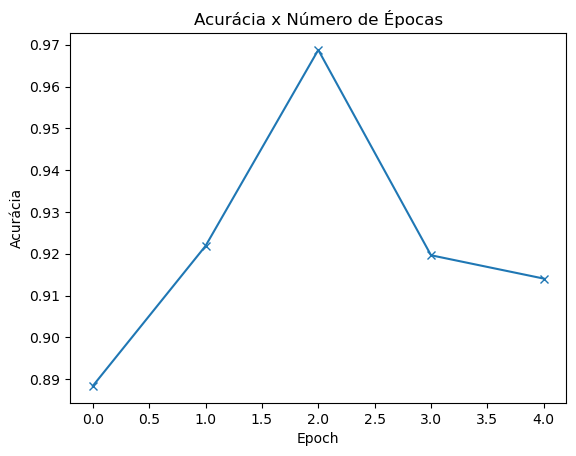

In [50]:
dsa_plot_acc(best_model.history)

In [51]:
# Plot
def dsa_plot_erro(history):
    train_losses = [x for x in history['train_loss']]
    val_losses = [x for x in history['val_loss']]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('Epoch')
    plt.ylabel('Erro')
    plt.legend(['Treinamento', 'Validação'])
    plt.title('Erro x Número de Épocas');

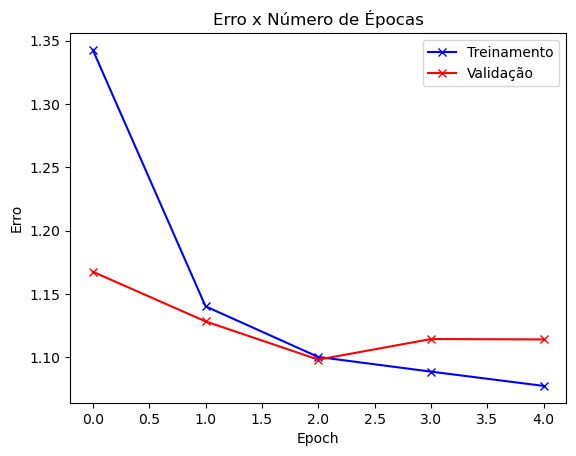

In [52]:
dsa_plot_erro(best_model.history)

In [53]:
# Coleta as acurácias de cada modelo
maxAccs = [model.maxAcc for model in loaded_models]
evalAccs = [model.evalAcc for model in loaded_models]

In [54]:
# Dataframe
acc_df = pd.DataFrame(zip(maxAccs, evalAccs), columns = ['maxAcc', 'evalAcc'], index = nomes_modelos)
acc_df['model_score'] = acc_df['maxAcc'] + acc_df['evalAcc']
acc_df

,maxAcc,evalAcc,model_score
ResNet18,0.945312,0.936384,1.881696
ResNet152,0.968750,0.921875,1.890625


Usaremos no deploy o modelo com maior model_score.

## Previsões com Dados de Teste

In [55]:
# Função para as previsões
def dsa_previsao_imagem(img, model):
    
    # Batch de 1
    xb = to_device(img.unsqueeze(0), device) 
    
    # Previsão
    yb = model(xb) 
    
    # Índice da probabilidade mais alta
    prob, preds  = torch.max(yb, dim = 1) 
    
    return dataset.classes[preds[0].item()]

Label: paper , Previsto: paper


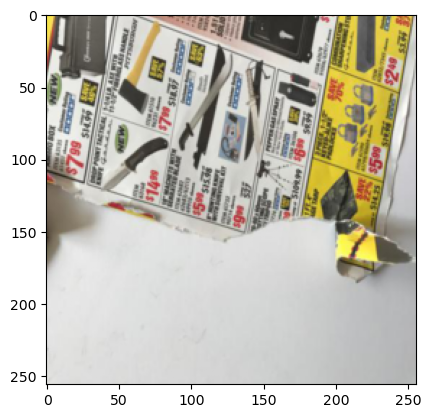

In [56]:
# Previsão
img, label = dados_teste[52]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Previsto:', dsa_previsao_imagem(img, best_model))

Label: metal , Previsto: metal


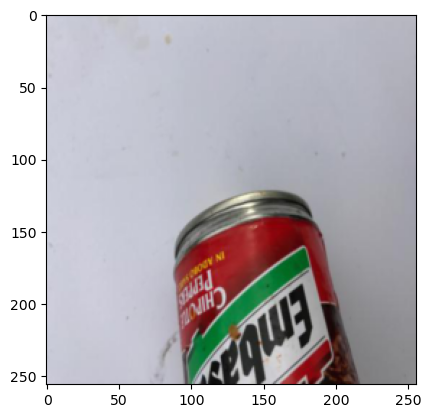

In [57]:
# Previsão
img, label = dados_teste[34]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Previsto:', dsa_previsao_imagem(img, best_model))

Label: paper , Previsto: paper


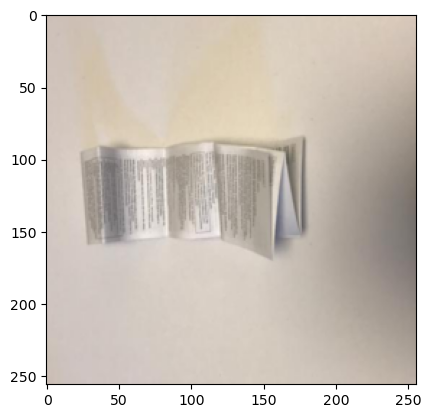

In [58]:
# Previsão
img, label = dados_teste[19]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Previsto:', dsa_previsao_imagem(img, best_model))

## Deploy e Uso do Modelo com Novas Imagens

In [59]:
# Pasta com novas imagens
img_dir = Path('novos_dados')

In [60]:
# Caminho para cada nova imagem
imagem1 = os.path.join(img_dir, 'imagem1.jpg')
imagem2 = os.path.join(img_dir, 'imagem2.jpg')
imagem3 = os.path.join(img_dir, 'imagem3.jpg')
imagem4 = os.path.join(img_dir, 'imagem4.jpg')
imagem5 = os.path.join(img_dir, 'imagem5.jpg')
imagem6 = os.path.join(img_dir, 'imagem6.jpg')

In [61]:
# Download das imagens (se não existirem em disco)
if not os.path.exists(imagem1): 
    urllib.request.urlretrieve("https://www.cargocabbie.ca/wp-content/uploads/2018/03/cargo-cabbie-shipping-box-12-x-9-x-6.jpg", imagem1)
if not os.path.exists(imagem2):
    urllib.request.urlretrieve("https://cdn.shopify.com/s/files/1/0669/3891/products/acc23b05-e02d-4a82-a113-5640d0fa634d_384x384.jpg?v=1634788809", imagem2)  
if not os.path.exists(imagem3):
    urllib.request.urlretrieve("https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Ftse4.mm.bing.net%2Fth%3Fid%3DOIP.2F0uH6BguQMctAYEJ-s-1gHaHb%26pid%3DApi&f=1", imagem3)  
if not os.path.exists(imagem4):
    urllib.request.urlretrieve("https://cdn.shopify.com/s/files/1/1722/0531/products/new-york-times-back-copies_1024x1024.jpg?v=1642632958", imagem4)
if not os.path.exists(imagem5):
    urllib.request.urlretrieve("https://discovery.sndimg.com/content/dam/images/discovery/fullset/2022/1/24/GettyImages-1325351577.jpg.rend.hgtvcom.406.406.suffix/1643047005309.jpeg", imagem5)
if not os.path.exists(imagem6):
    urllib.request.urlretrieve("https://livermorerecycles.org/wp-content/uploads/2018/04/bar-wrapper.jpg", imagem6)

In [62]:
# Função para as previsões
def dsa_classifica_imagem(img_path):
    
    # Carrega imagem
    image = Image.open(img_path)
    
    # Aplica mesma transformação aplicada antes do treino
    example_image = transformador(image)
    
    # Plot
    plt.imshow(example_image.permute(1, 2, 0))
    print("Previsão para a imagem:", dsa_previsao_imagem(example_image, best_model) + ".")

Previsão para a imagem: cardboard.


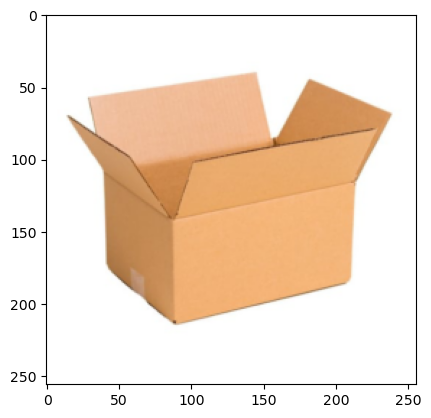

In [63]:
dsa_classifica_imagem(imagem1)

Previsão para a imagem: glass.


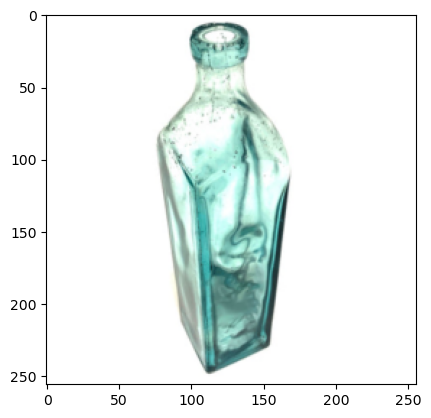

In [64]:
dsa_classifica_imagem(imagem2)

Previsão para a imagem: metal.


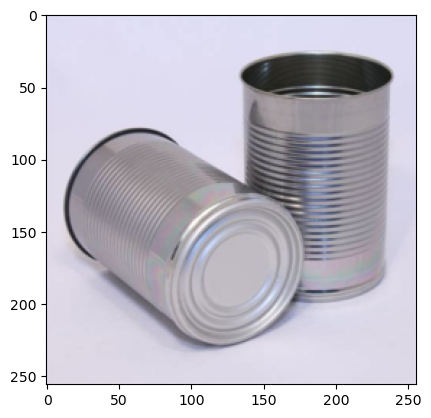

In [65]:
dsa_classifica_imagem(imagem3)

Previsão para a imagem: paper.


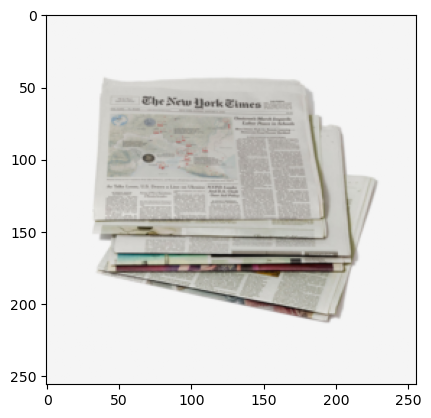

In [66]:
dsa_classifica_imagem(imagem4)

Previsão para a imagem: paper.


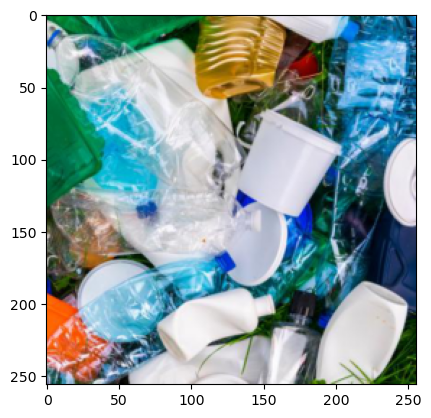

In [67]:
dsa_classifica_imagem(imagem5)

Previsão para a imagem: metal.


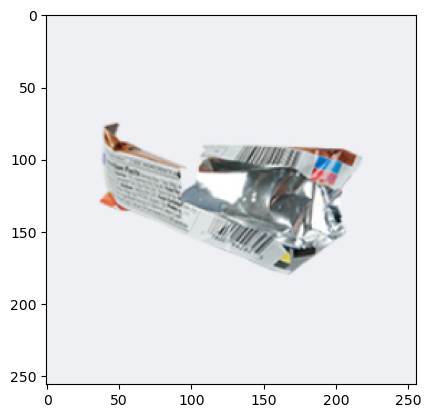

In [68]:
dsa_classifica_imagem(imagem6)

In [69]:
%reload_ext watermark
%watermark -a "Data Science Academy"

Author: Data Science Academy



In [70]:
#%watermark -v -m

In [71]:
#%watermark --iversions

<!-- Projeto Desenvolvido na Data Science Academy - www.datascienceacademy.com.br -->
# Fim